In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots 
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import glob
import os

%matplotlib inline

# Import and combine data

In [2]:
# List of data files in folder ../data/raw/
!ls ../data/raw/

TsaThroughput.ANC.csv   TsaThroughput.FLL.csv   TsaThroughput.PHX.csv
TsaThroughput.ATL.csv   TsaThroughput.LAS.csv   TsaThroughput.SEA.csv
TsaThroughput.All.csv   TsaThroughput.LAX.csv   TsaThroughput.SFO.csv
TsaThroughput.BOI.csv   TsaThroughput.MCO.csv   TsaThroughput.SJC.csv
TsaThroughput.BZN.csv   TsaThroughput.MIA.csv   TsaThroughput.TPA.csv
TsaThroughput.DEN.csv   TsaThroughput.MSO.csv   TsaThroughput.Total.csv
TsaThroughput.DFW.csv   TsaThroughput.PDX.csv


In [3]:
def multiple_csv_to_dict(path):
    '''Reads multiple csv files from a given path
    and combines into a single dictionary'''
    
    files = glob.glob(path)

    data = []
    names = []

    for file in files:
        df = pd.read_csv(file)
        data.append(df)
        names.append(file.split('.')[-2])
    
    return dict(zip(names, data))

In [4]:
# Create a dictionary with airport acronyms as keys and content of csv files as values
airport_dict = multiple_csv_to_dict('../data/raw/*.*.csv')
airport_dict.keys()

dict_keys(['DFW', 'SEA', 'Total', 'DEN', 'SFO', 'LAX', 'BOI', 'BZN', 'MSO', 'TPA', 'MIA', 'PHX', 'LAS', 'PDX', 'FLL', 'MCO', 'All', 'ANC', 'ATL', 'SJC'])

In [5]:
# Want to keep individual airport data; pop out 'Total' and 'All' 
airport_dict.pop('Total')
airport_dict.pop('All')
airport_dict.keys()

dict_keys(['DFW', 'SEA', 'DEN', 'SFO', 'LAX', 'BOI', 'BZN', 'MSO', 'TPA', 'MIA', 'PHX', 'LAS', 'PDX', 'FLL', 'MCO', 'ANC', 'ATL', 'SJC'])

In [6]:
def make_individual_dfs(df, name):
    '''For each airport, create dataframe, set index to datetime, 
    sum over values for all gates and drop unnecessary columns'''

    # Set index to datetime
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
    df = df.drop(columns=['Date', 'Hour'])
    
    # Sum across values from each gate to get total for a given date and time (up to the hour)
    df = pd.DataFrame(df.sum(axis=1))
    df.rename(columns={0:name}, inplace=True)
    
    return df

In [7]:
def join_airports(list_names):
    '''Combines resulting dataframes into a single dataframe'''
    
    airports=[]
    
    for name in list_names: 
        airports.append(make_individual_dfs(airport_dict.get(name), name))
        airport_df = pd.concat(airports, axis=1)
    
    return airport_df

In [8]:
# Created a sorted list of airport names
airport_names = [name for name in airport_dict.keys()]
airport_names.sort()

In [9]:
# Dataframe of TSA throughput for all airports (all gates)
df = join_airports(airport_names)
df.head()

ANC     ATL    BOI    BZN     DEN     DFW     FLL  \
2018-12-30 00:00:00  115.0    11.0    NaN    NaN   123.0     NaN     0.0   
2018-12-30 01:00:00   14.0    14.0    NaN    NaN    52.0     NaN   147.0   
2018-12-30 02:00:00   29.0    10.0    NaN    NaN    19.0     NaN     NaN   
2018-12-30 03:00:00  115.0   216.0    NaN   25.0   353.0   351.0   396.0   
2018-12-30 04:00:00  305.0  1308.0  483.0  331.0  3006.0  2140.0  3217.0   

                        LAS     LAX     MCO     MIA    MSO     PDX     PHX  \
2018-12-30 00:00:00   343.0   533.0     NaN   283.0    NaN    14.0   389.0   
2018-12-30 01:00:00    84.0    11.0     NaN   290.0    NaN    11.0    64.0   
2018-12-30 02:00:00    60.0     NaN     NaN   314.0    NaN    24.0    16.0   
2018-12-30 03:00:00   762.0   474.0   535.0   704.0    NaN   527.0   524.0   
2018-12-30 04:00:00  3189.0  3778.0  3501.0  1796.0  190.0  1778.0  1919.0   

                        SEA     SFO    SJC     TPA  
2018-12-30 00:00:00    50.0   318.0    NaN     1.0  
2018-12-30 01:00:00    12.0     7.0    NaN     NaN  
2018-12-30 02:00:00   110.0     NaN    NaN     NaN  
2018-12-30 03:00:00   717.0   195.0   35.0    20.0  
2018-12-30 04:00:00  3114.0  2361.0  420.0  2267.0

* ANC - Anchorage
* ATL - Atlanta
* BOI - Boise
* BZN - Bozeman
* DEN - Denver
* DFW - Dallas Fort Worth
* FLL - Fort Lauderdale
* LAS - Las Vegas
* LAX - Los Angeles
* MCO - Orlando
* MIA - Miami
* MSO - Missoula Montana
* PDX - Portland
* SEA - Seattle
* SFO - San Francisco
* SJC - San Jose
* TPA - Tampa

# Explore data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27216 entries, 2018-12-30 00:00:00 to 2022-02-05 23:00:00
Freq: H
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ANC     26985 non-null  float64
 1   ATL     26513 non-null  float64
 2   BOI     19626 non-null  float64
 3   BZN     17779 non-null  float64
 4   DEN     27186 non-null  float64
 5   DFW     24839 non-null  float64
 6   FLL     23792 non-null  float64
 7   LAS     27215 non-null  float64
 8   LAX     25785 non-null  float64
 9   MCO     24941 non-null  float64
 10  MIA     27211 non-null  float64
 11  MSO     16701 non-null  float64
 12  PDX     27206 non-null  float64
 13  PHX     27215 non-null  float64
 14  SEA     27214 non-null  float64
 15  SFO     25581 non-null  float64
 16  SJC     20325 non-null  float64
 17  TPA     21527 non-null  float64
dtypes: float64(18)
memory usage: 3.9 MB


In [11]:
# Shape of dataframe
df.shape

(27216, 18)

In [12]:
# Summary statistics
df.describe().T

count         mean          std  min    25%     50%     75%      max
ANC  26985.0   210.573967   154.729967  0.0   95.0   180.0   287.0   1094.0
ATL  26513.0  2148.751198  1829.063290  0.0  267.0  1912.0  3609.0   8202.0
BOI  19626.0   270.544966   199.508061  0.0  104.0   245.0   397.0   1292.0
BZN  17779.0   139.272962   128.619313  0.0   43.0   103.0   196.0    830.0
DEN  27186.0  1949.017527  1586.510462  0.0  393.0  1758.0  3328.0   6642.0
DFW  24839.0  1994.838661  1540.055232  0.0  440.0  1888.0  3265.0   6770.0
FLL  23792.0  1784.690232  1197.076639  0.0  653.0  1883.0  2743.0   5507.0
LAS  27215.0  1948.071835  1508.062165  0.0  466.5  1816.0  3158.0   6385.0
LAX  25785.0  3097.091061  2323.019113  0.0  992.0  2751.0  4928.0  10250.0
MCO  24941.0  2273.608476  1717.449356  0.0  441.0  2304.0  3848.0   6973.0
MIA  27211.0  1800.251038  1500.972535  0.0  230.5  1675.0  3118.0   5888.0
MSO  16701.0    69.071014    60.145189  0.0   23.0    53.0   100.0    546.0
PDX  27206.0   712.149452   658.641149  0.0  123.0   550.0  1165.0   3417.0
PHX  27215.0  1594.688958  1271.473170  0.0  380.0  1388.0  2676.0   5779.0
SEA  27214.0  1486.599802  1273.462556  0.0  324.0  1198.5  2445.0   5483.0
SFO  25581.0  1778.937219  1565.285951  0.0  394.0  1311.0  2917.0   6782.0
SJC  20325.0   659.242263   522.936578  0.0  221.0   529.0  1031.0   2700.0
TPA  21527.0  1219.088075   828.289392  0.0  480.0  1277.0  1855.0   3981.0

In [13]:
# Are there any duplicates?
df.duplicated().any()

False

## Visualize the distribution of data

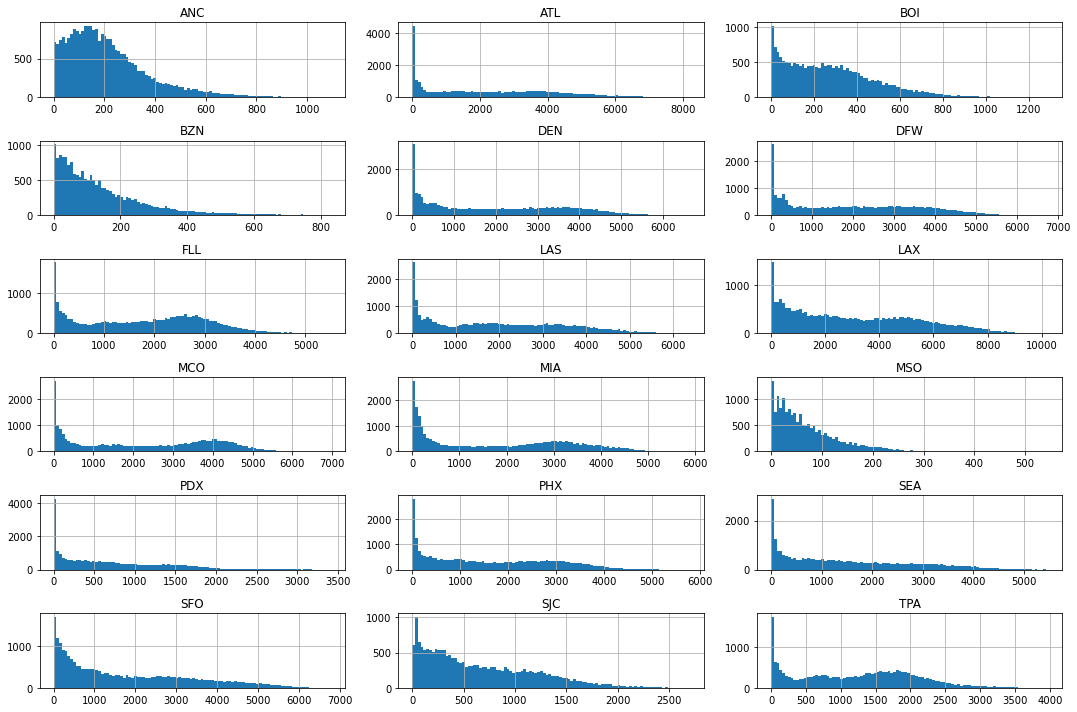

In [14]:
# Histograms of each airport 
df.hist(figsize=(15,10), layout=(6,3), bins=100)
plt.tight_layout();

In [15]:
# Sort by median value in descending order
sorted_index = df.median().sort_values(ascending=False).index
sorted_index

Index(['LAX', 'MCO', 'ATL', 'DFW', 'FLL', 'LAS', 'DEN', 'MIA', 'PHX', 'SFO',
       'TPA', 'SEA', 'PDX', 'SJC', 'BOI', 'ANC', 'BZN', 'MSO'],
      dtype='object')

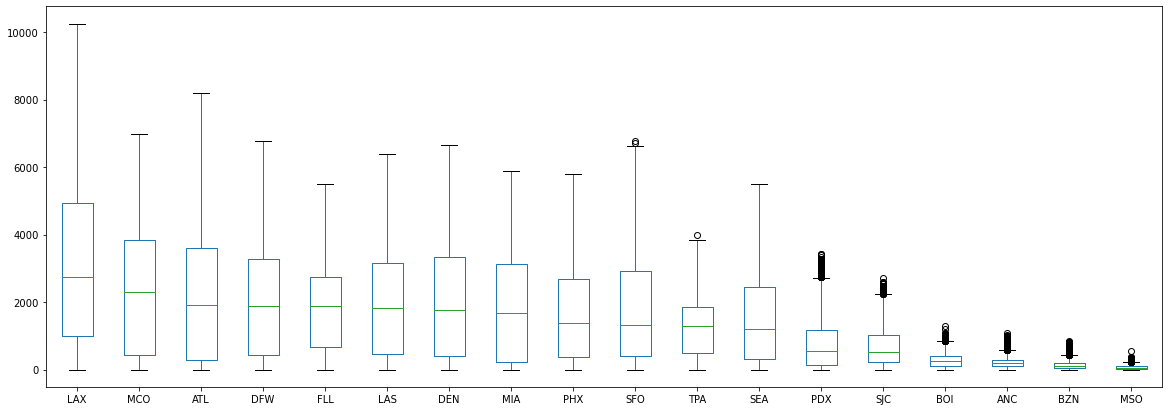

In [16]:
# Boxplot of airport data sorted by median in descending order
df[sorted_index].boxplot(figsize=(20,7),grid=False);

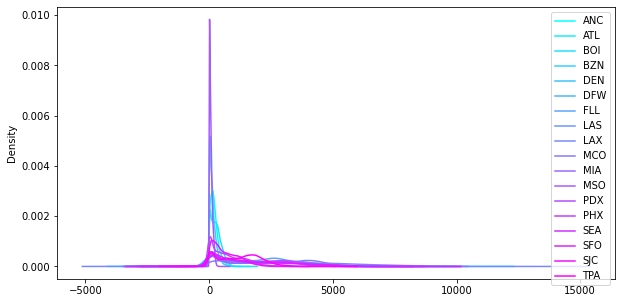

In [17]:
# Density plots for all airports
df.plot(kind='density', figsize=(10,5), colormap='cool');

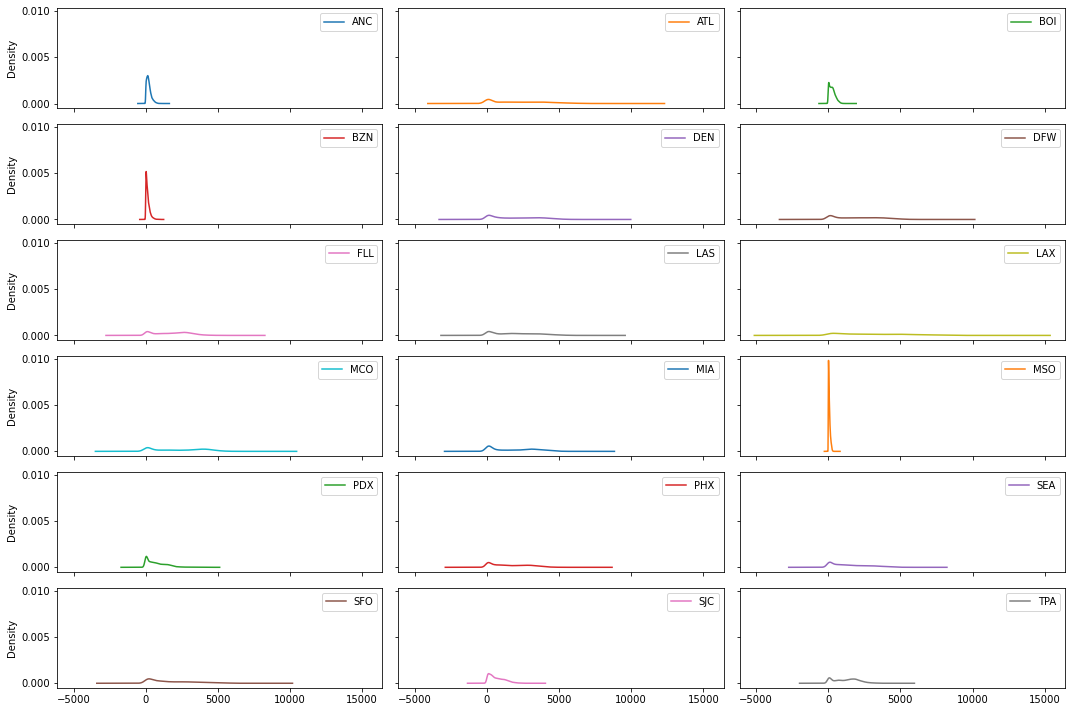

In [18]:
# Density plots on the same y scale
df.plot(kind='density', figsize=(15,10), layout=(6,3), subplots=True, sharex=True, sharey=True)
plt.tight_layout();

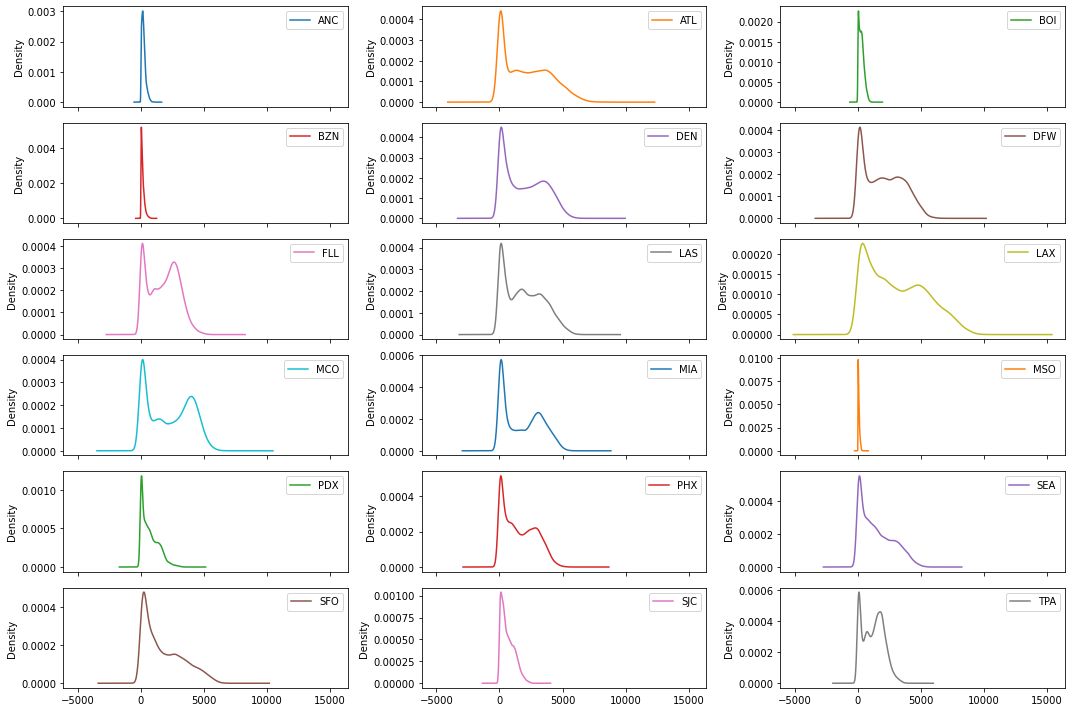

In [19]:
# Density plots with different y scales
df.plot(kind='density', figsize=(15,10), layout=(6,3), subplots=True, sharex=True)
plt.tight_layout();

## Timeseries plots

In [20]:
def plot_timeseries(series, figsize=(20,8), cmap=None):
    '''Given columns and slices of dataframe, plots timeseries of data'''
    
    ax = series.plot(figsize=figsize, cmap=cmap)
    ax.set_xlabel('Date and time')
    ax.set_ylabel('Throughput (count)')
    ax.set_title('TSA Throughput Timeseries')
    
    plt.show()

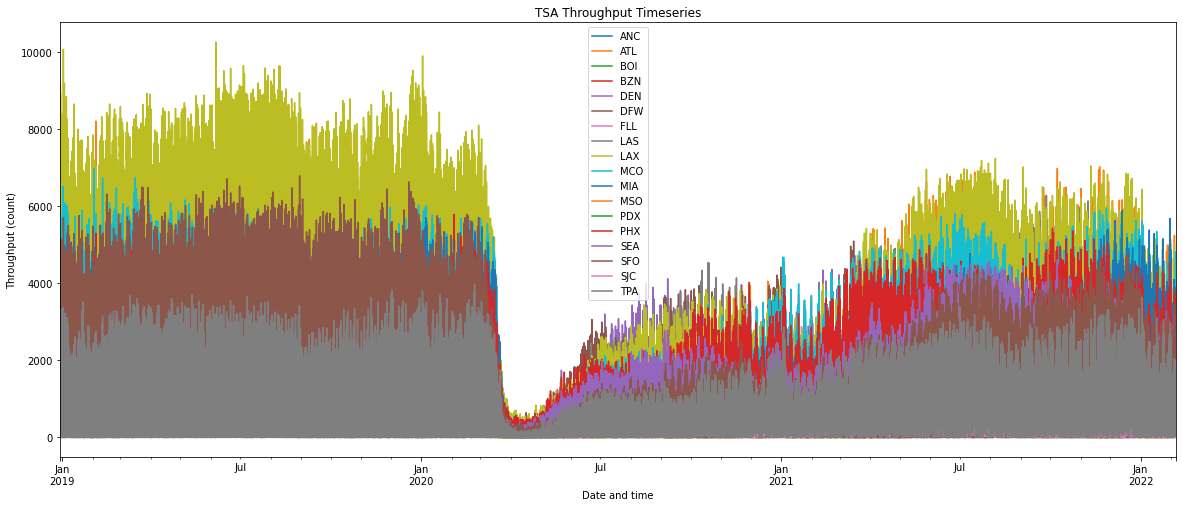

In [21]:
# Timeseries plot for all airports
plot_timeseries(df)

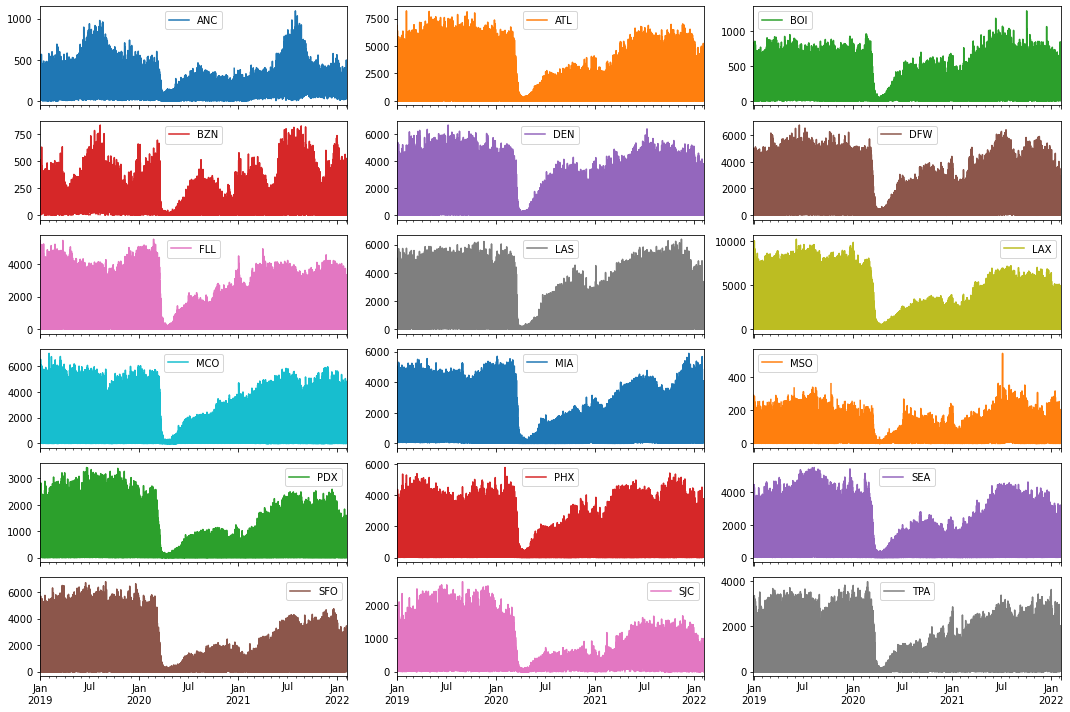

In [22]:
# Timeseries plot for all airports (not on same y scale)
df.plot(figsize=(15,10), layout=(6,3), subplots=True, sharex=True)
plt.tight_layout();

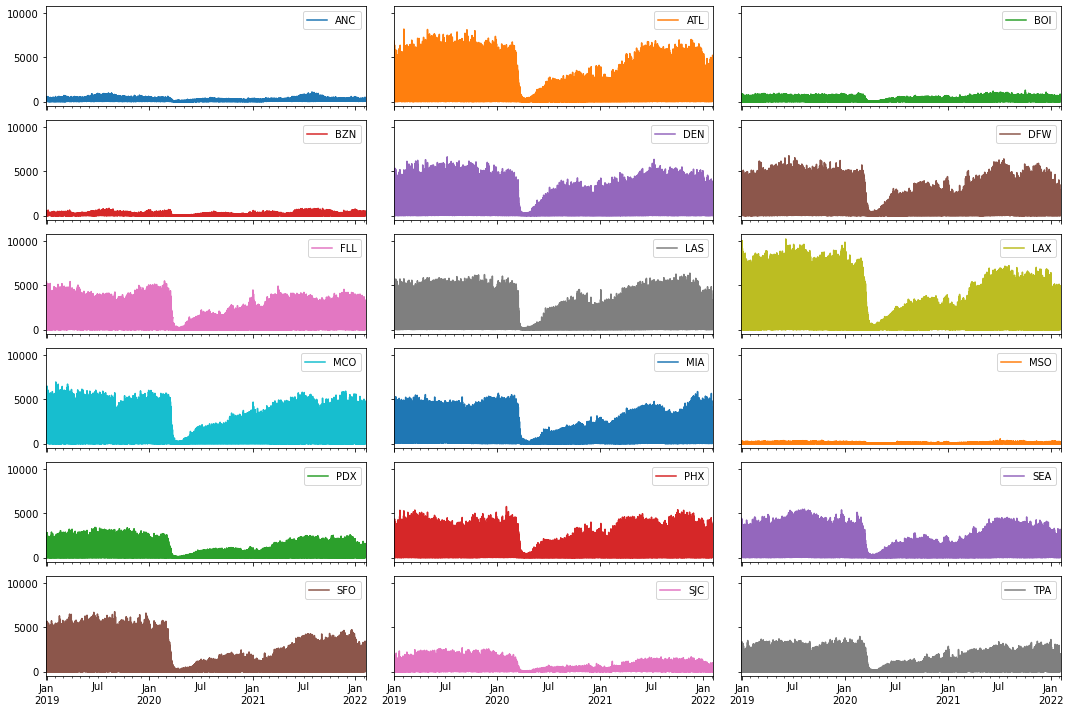

In [23]:
# Timeseries plots for each airports using same scale for the y-axis 
df.plot(figsize=(15,10), layout=(6,3), subplots=True, sharex=True, sharey=True)
plt.tight_layout();

## Treatment of NA values

In [24]:
# How many null values?
null_values = pd.DataFrame(df.isna().sum().sort_values(ascending=False), columns=['count'])
null_values['percent'] = round(df.isna().mean()*100, 2)
null_values

count  percent
MSO  10515    38.64
BZN   9437    34.67
BOI   7590    27.89
SJC   6891    25.32
TPA   5689    20.90
FLL   3424    12.58
DFW   2377     8.73
MCO   2275     8.36
SFO   1635     6.01
LAX   1431     5.26
ATL    703     2.58
ANC    231     0.85
DEN     30     0.11
PDX     10     0.04
MIA      5     0.02
SEA      2     0.01
LAS      1     0.00
PHX      1     0.00

In [25]:
def barplots(df):
    '''Barplots of hours with NA values'''
    
    fig, axs = plt.subplots(6, 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Null Value distribution by hour', fontsize=18, y=1)

    for column, ax in zip(df.columns, axs.ravel()):
        df[df[column].isna()].index.hour.value_counts().plot(kind='bar', ax=ax)
        ax.set_title(column)
    plt.tight_layout()
    plt.show()

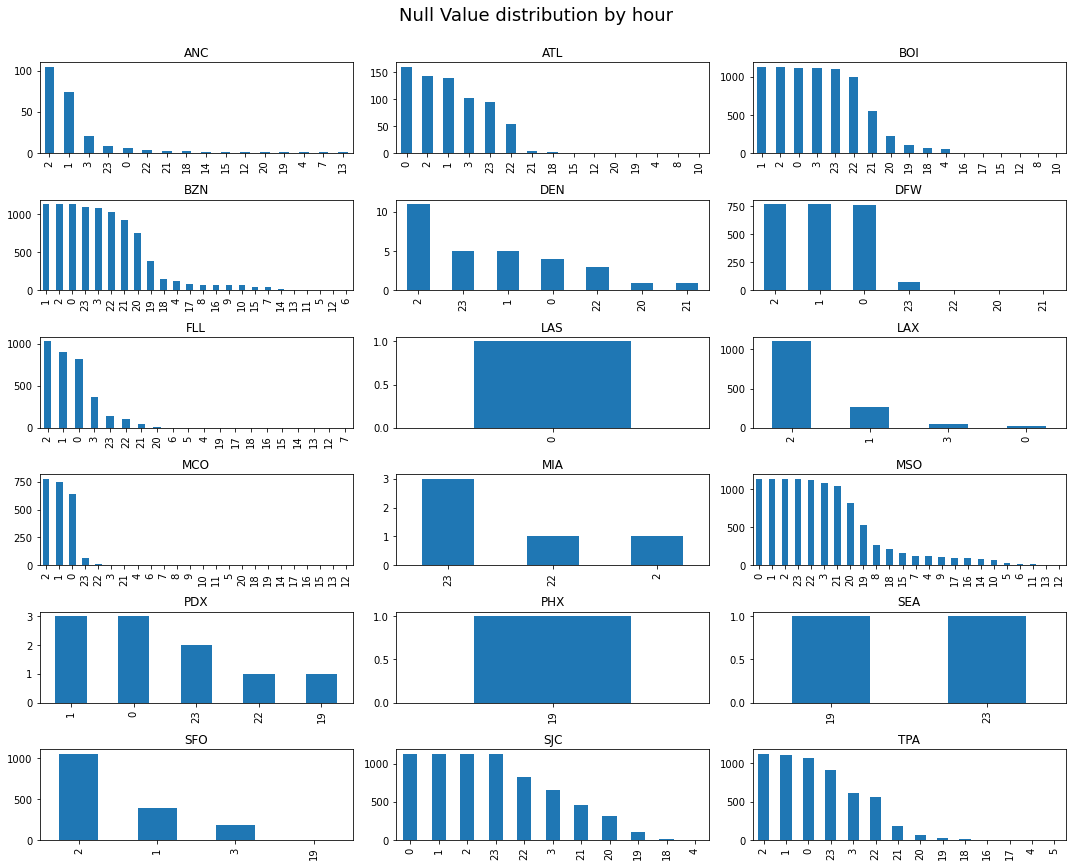

In [26]:
# Plot NA values for each airport
barplots(df)

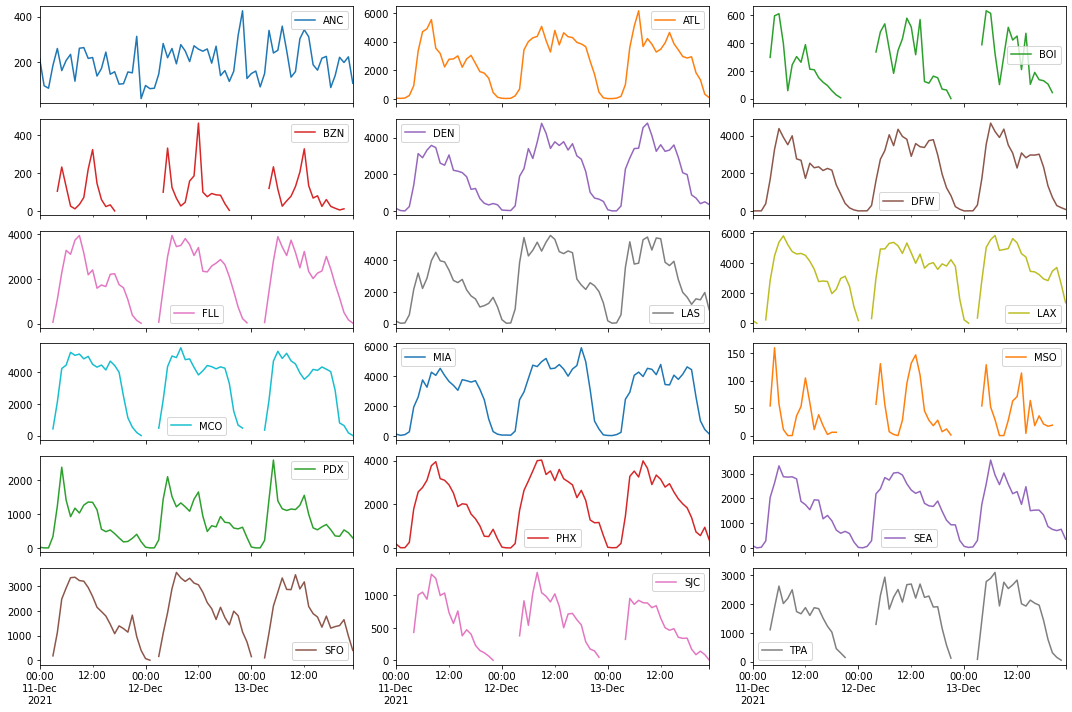

In [27]:
# Timeseries plots for each airports using same scale for the y-axis 
df['2021-12-11':'2021-12-13'].plot(figsize=(15,10), layout=(6,3), subplots=True, sharex=True)
plt.tight_layout();

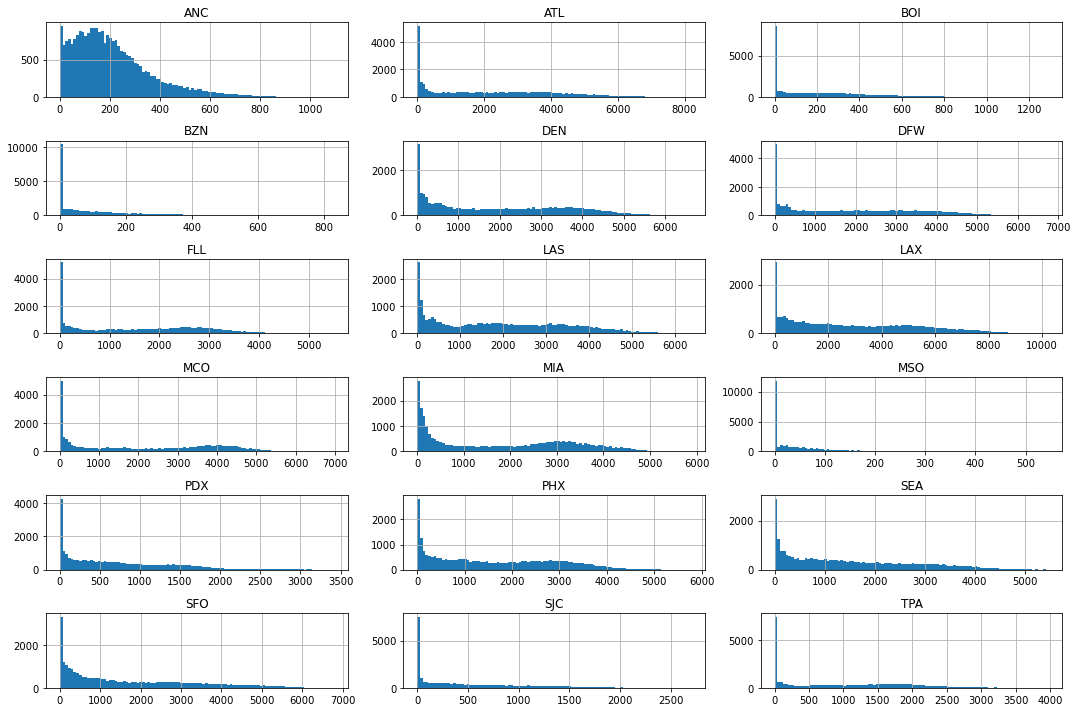

In [28]:
# Histograms of each airport with all NA as zero
df_nona = df.fillna(0)
df_nona.hist(figsize=(15,10), layout=(6,3), bins=100)
plt.tight_layout();

In [29]:
# Sort by median value in descending order after imputing NA values with zero
sorted_index_nona = df_nona.median().sort_values(ascending=False).index
sorted_index_nona

Index(['LAX', 'MCO', 'ATL', 'LAS', 'DEN', 'MIA', 'DFW', 'FLL', 'PHX', 'SEA',
       'SFO', 'TPA', 'PDX', 'SJC', 'ANC', 'BOI', 'BZN', 'MSO'],
      dtype='object')

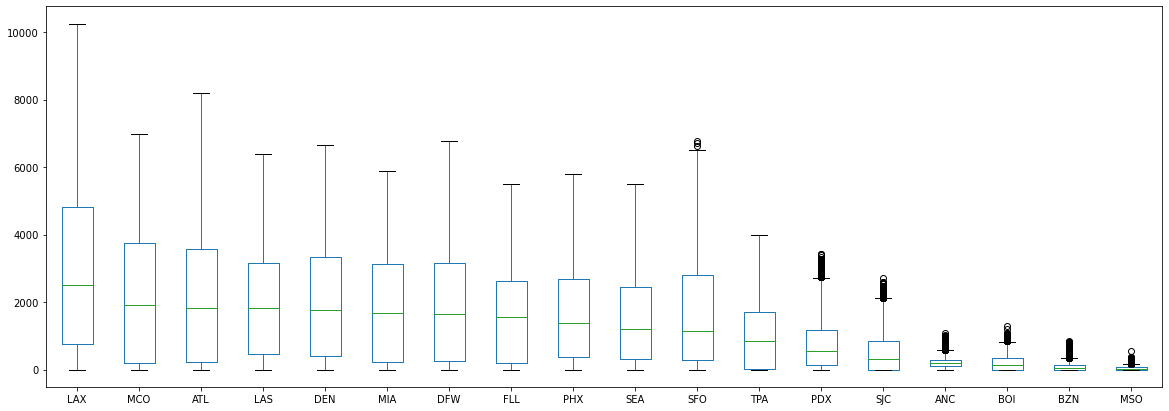

In [30]:
# Boxplot of airport data sorted by median in descending order after imputing NA values with zero
df_nona[sorted_index_nona].boxplot(figsize=(20,7),grid=False);

## Timeseires slices

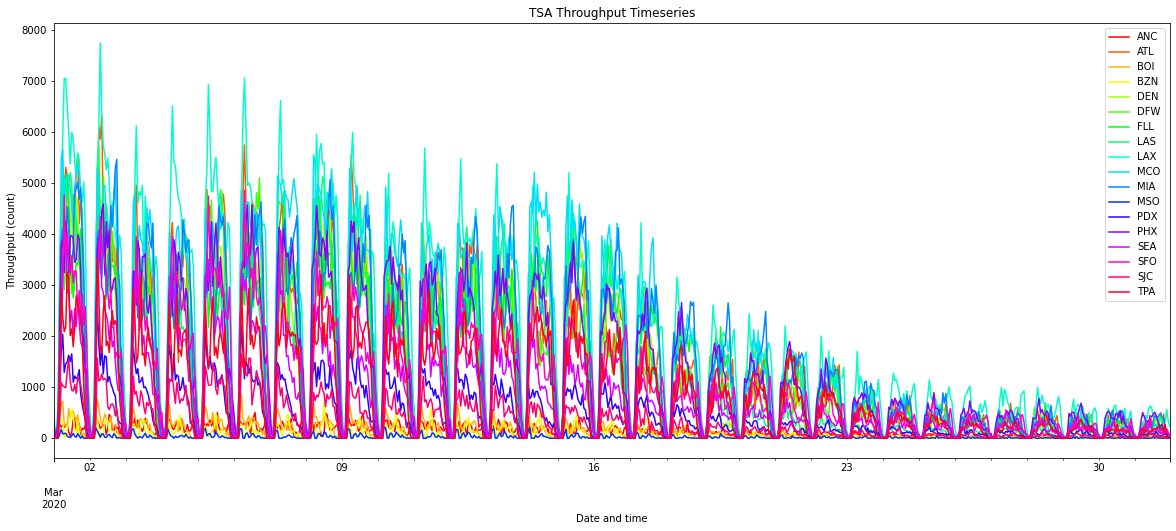

In [31]:
# Single month - March 2020
plot_timeseries(df_nona.loc['03-2020'], cmap='hsv')

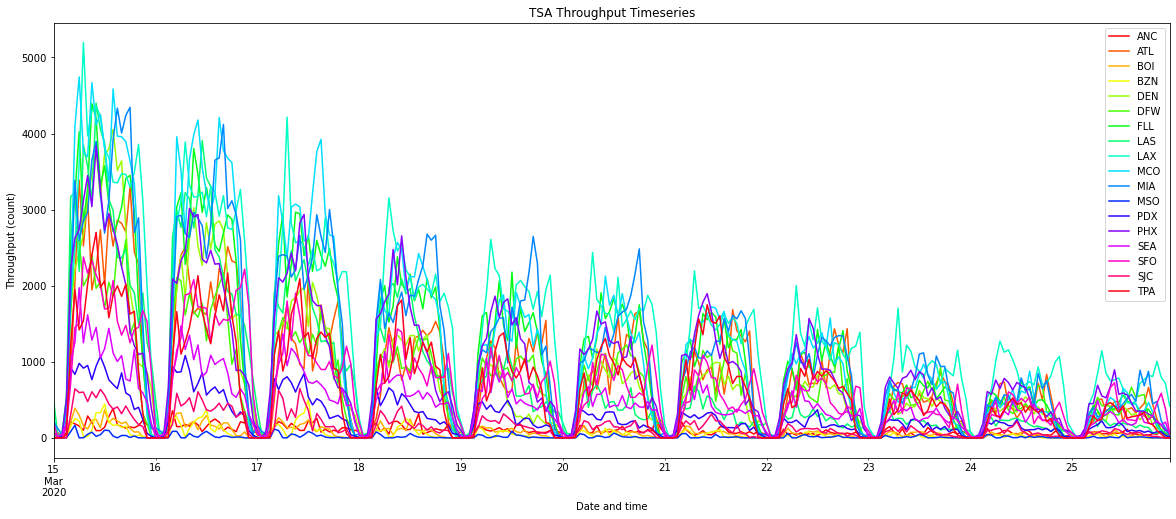

In [32]:
# Period of 10 days - March 15th until march 25th, 2020
plot_timeseries(df_nona.loc['15-03-2020':'25-03-2020'], cmap='hsv')

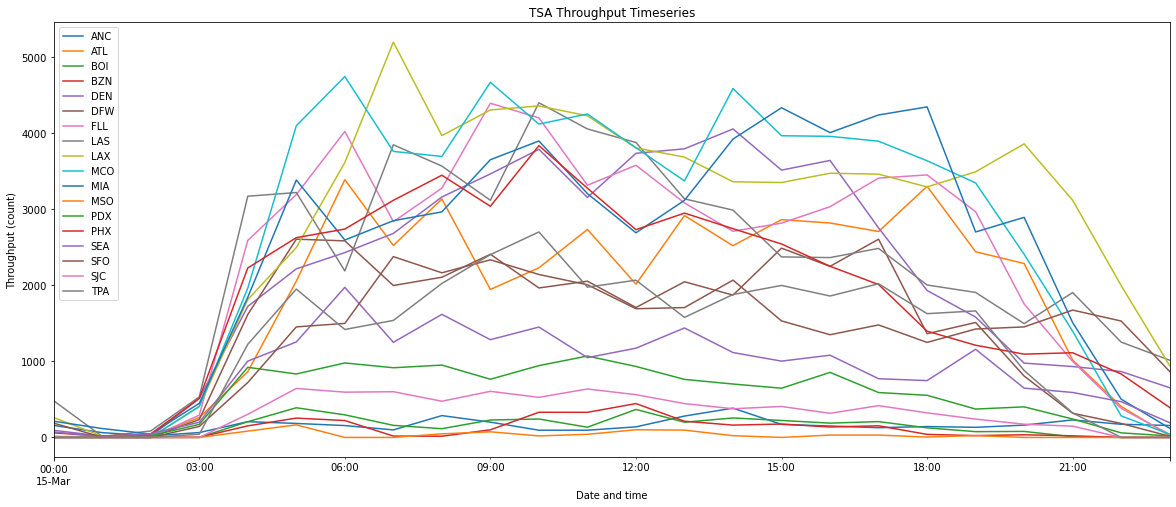

In [33]:
# Single day - March 15th 2020
plot_timeseries(df_nona.loc['15-03-2020'])

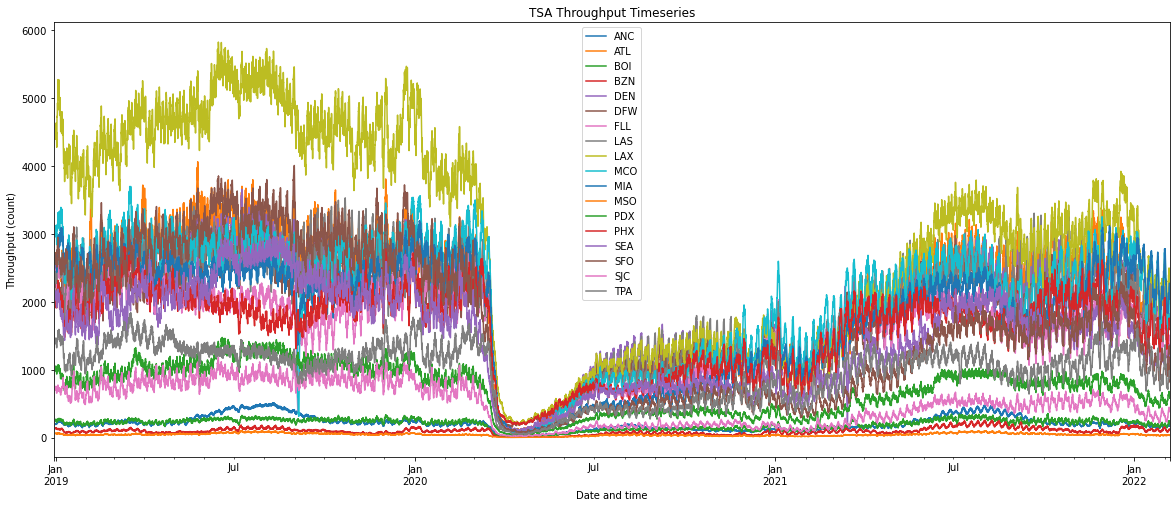

In [34]:
# Rolling average, window=50
plot_timeseries(df_nona.rolling(window=50).mean())

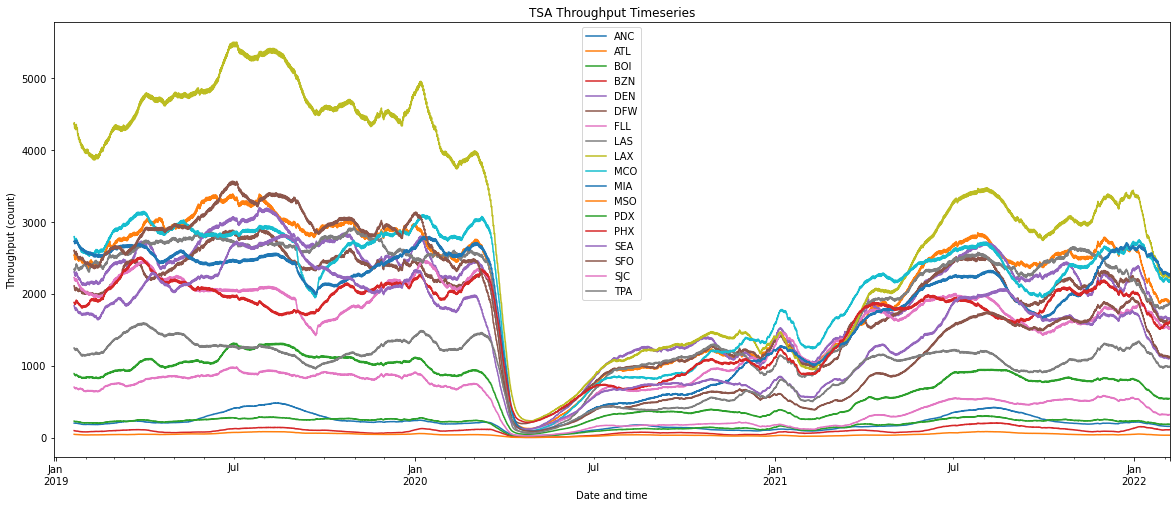

In [35]:
# Rolling average, window=500
plot_timeseries(df_nona.rolling(window=500).mean())

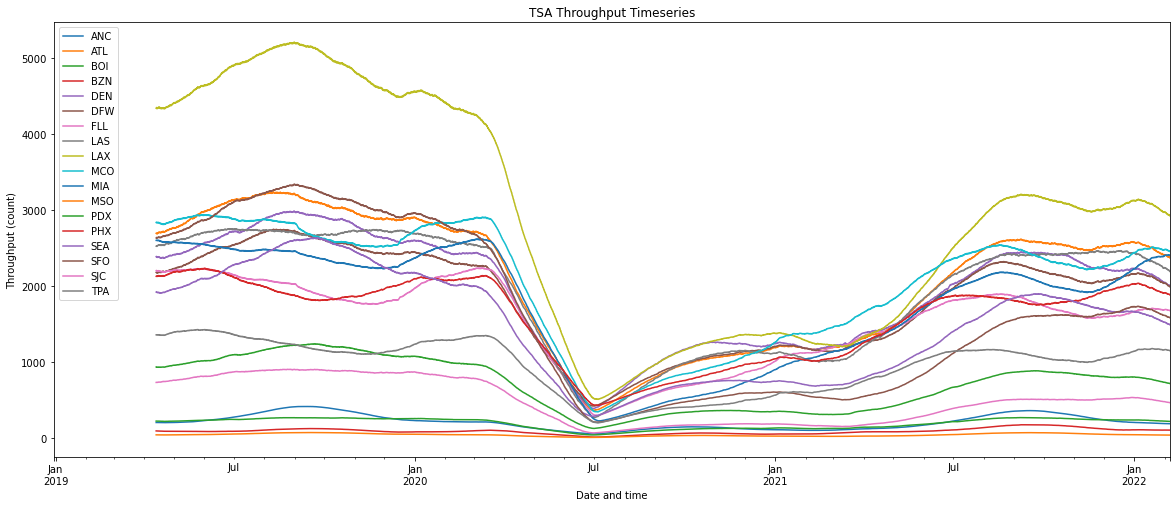

In [36]:
# Rolling average, window=2500
plot_timeseries(df_nona.rolling(window=2500).mean())

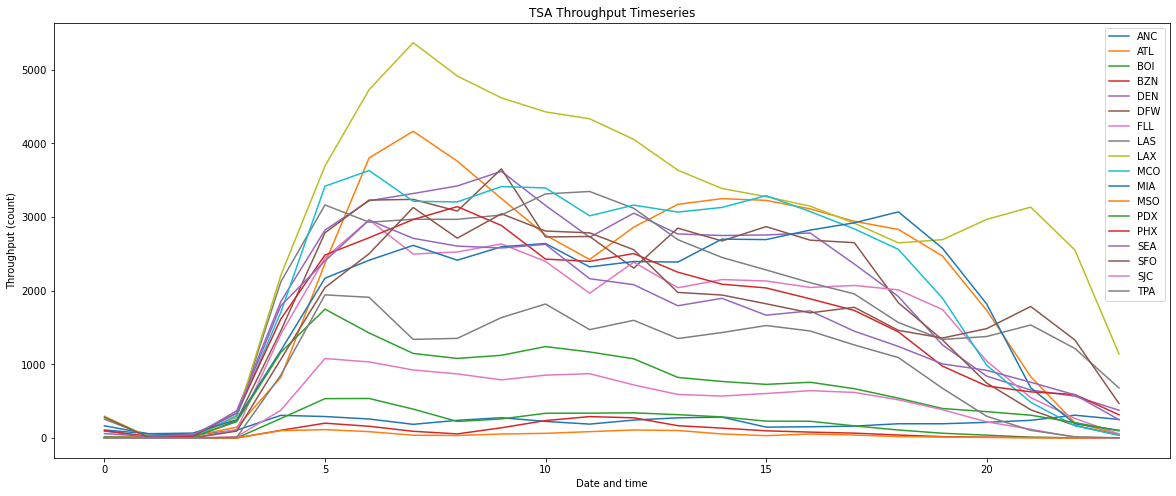

In [37]:
# Average hourly counts
plot_timeseries(df_nona.groupby(df.index.hour).mean())

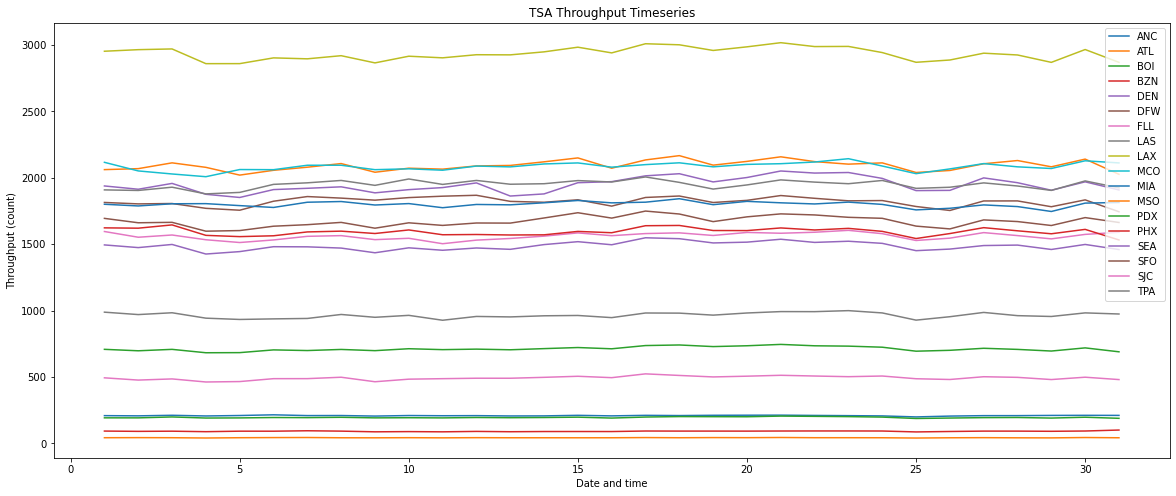

In [38]:
# Average daily counts
plot_timeseries(df_nona.groupby(df.index.day).mean())

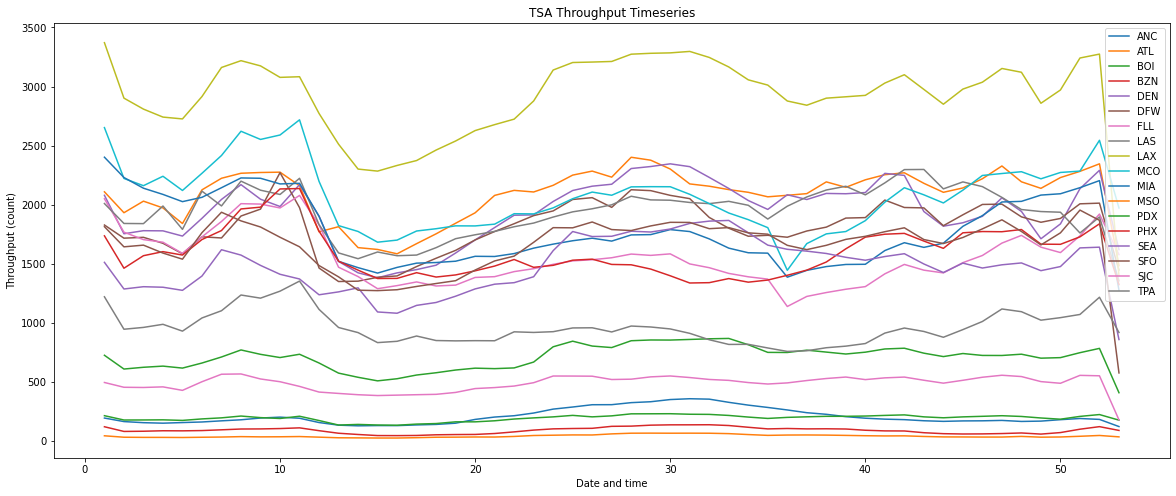

In [39]:
# Average weekly counts
plot_timeseries(df_nona.groupby(df.index.isocalendar().week).mean())

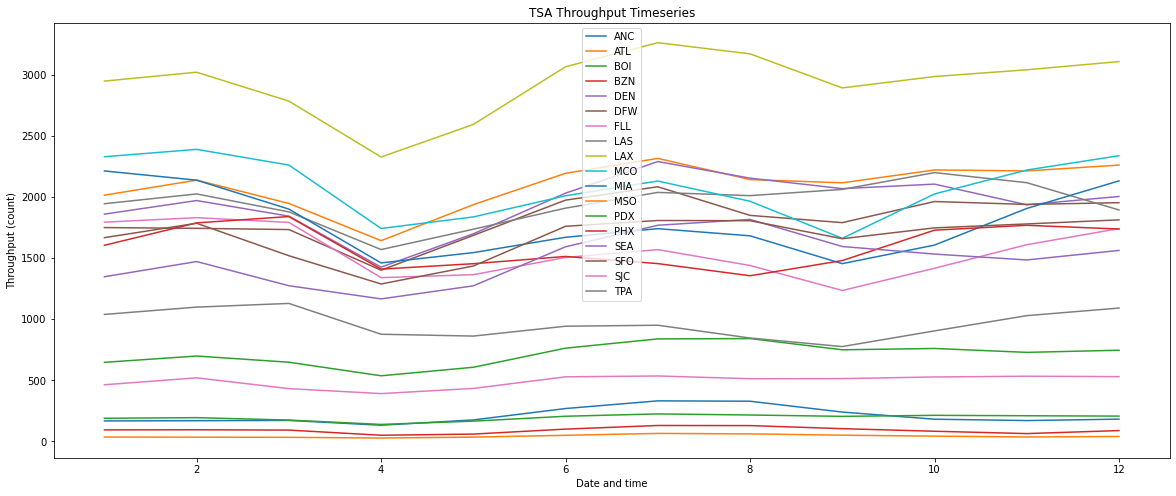

In [40]:
# Average monthly counts
plot_timeseries(df_nona.groupby(df.index.month).mean())

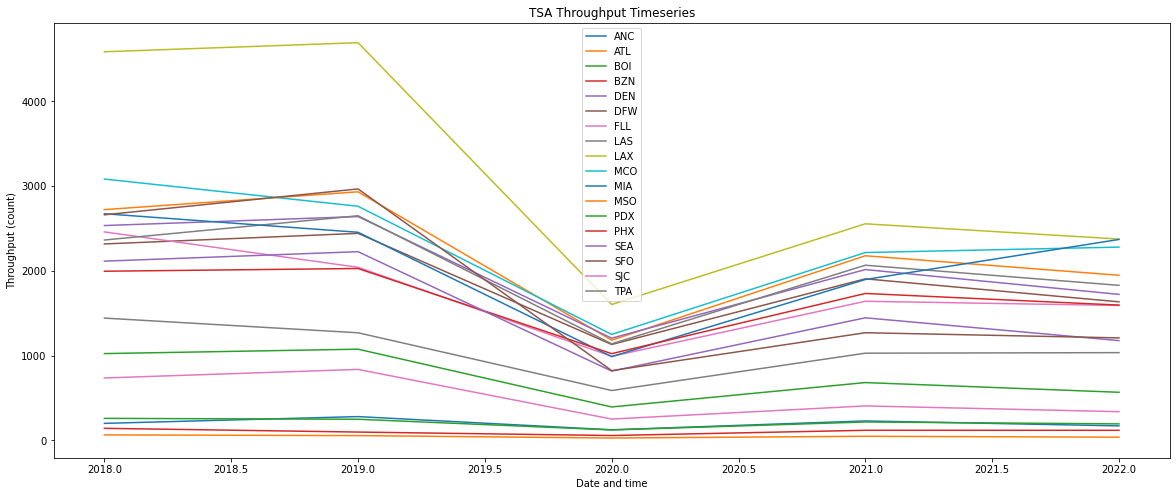

In [41]:
# Average yearly counts 
plot_timeseries(df_nona.groupby(df.index.year).mean())

# Correlation between different airports

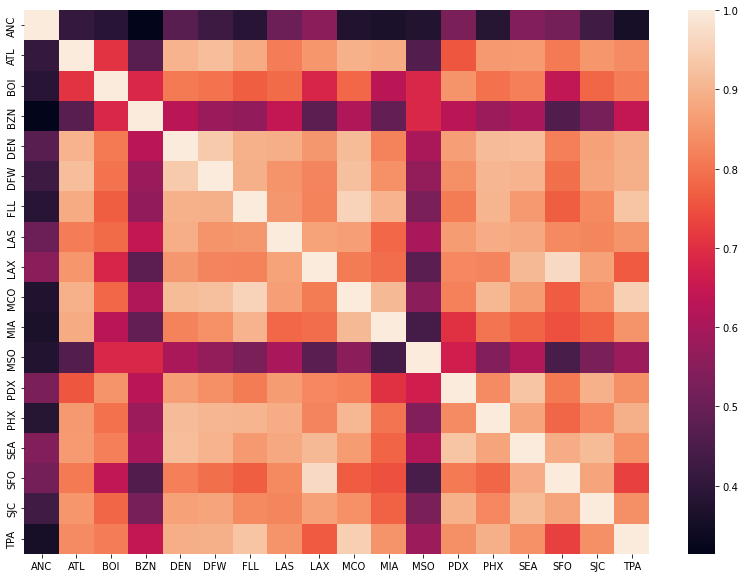

In [42]:
# Heatmap
plt.subplots(figsize=(14,10))
sns.heatmap(df_nona.corr());

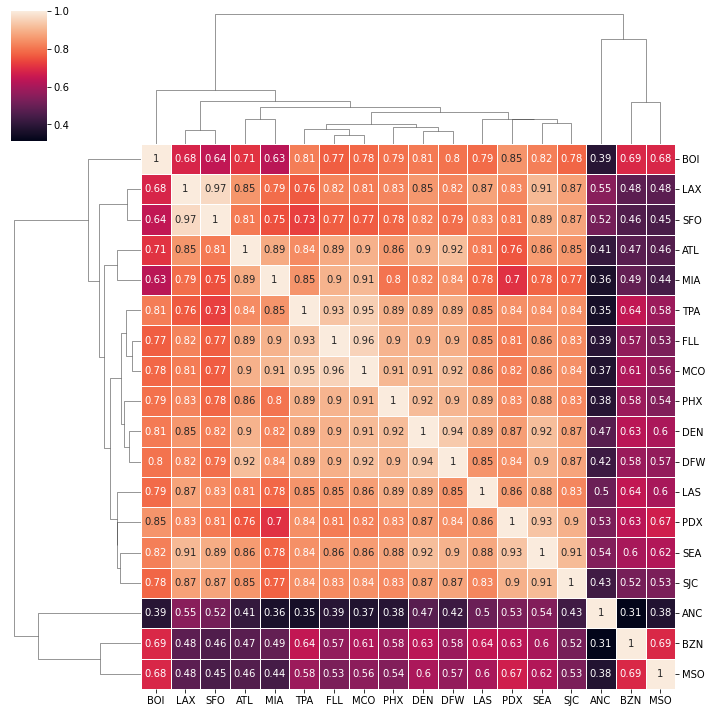

In [43]:
# Clustermap
sns.clustermap(df_nona.corr(), annot=True, linewidth=0.5);

## Autocorrelation Function

In [44]:
def plot_autocorrelation(df, lags=50):
    '''Plot autocorrelation plots for each timeseries in a dataframe'''
    
    fig, axs = plt.subplots(6, 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Autocorrelation', fontsize=18, y=0.95)

    for column, ax in zip(df.columns, axs.ravel()):
        tsaplots.plot_acf(df[column], ax=ax, lags=lags)
        ax.set_title(column)
    plt.show()

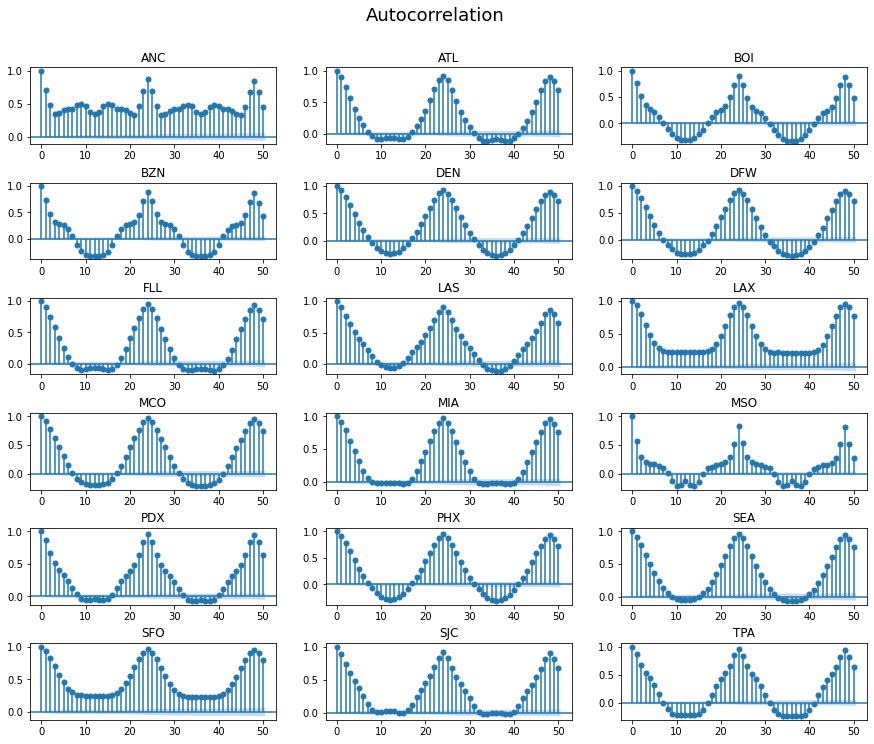

In [45]:
# Autocorrelation for each column, 50 lags
plot_autocorrelation(df_nona)

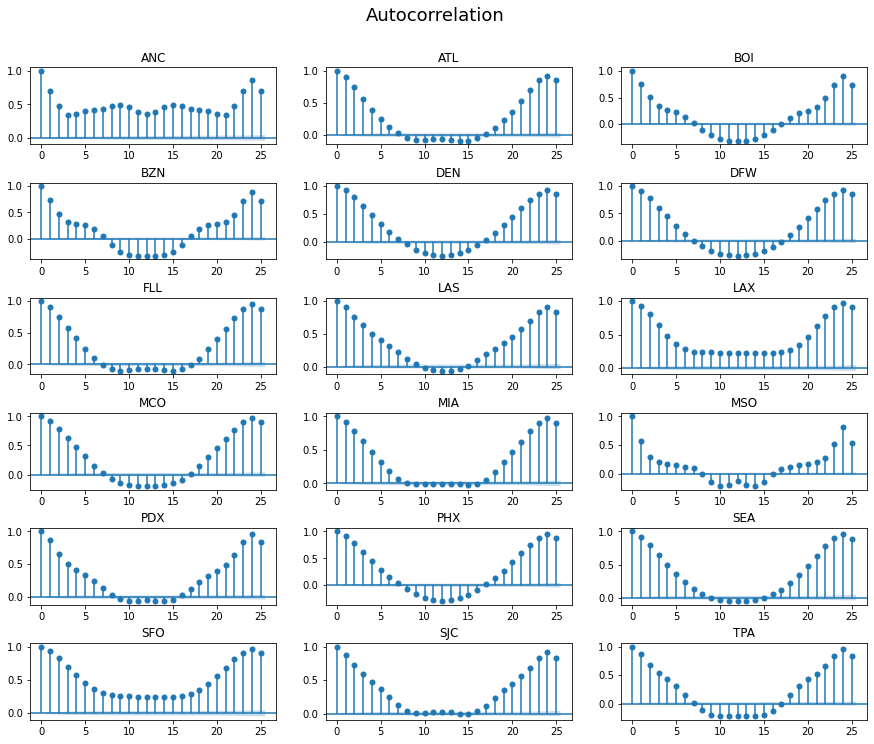

In [46]:
# Autocorrelation for each column, 20 lags
plot_autocorrelation(df_nona, 25)

## Partial autocorrelation Function

In [47]:
def plot_partial_autocorrelation(df, lags=50):
    '''Plot autocorrelation plots for each timeseries in a dataframe'''
    
    fig, axs = plt.subplots(6, 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Partial Autocorrelation', fontsize=18, y=0.95)

    for column, ax in zip(df.columns, axs.ravel()):
        tsaplots.plot_pacf(df[column], ax=ax, lags=lags)
        ax.set_title(column)
    plt.show()

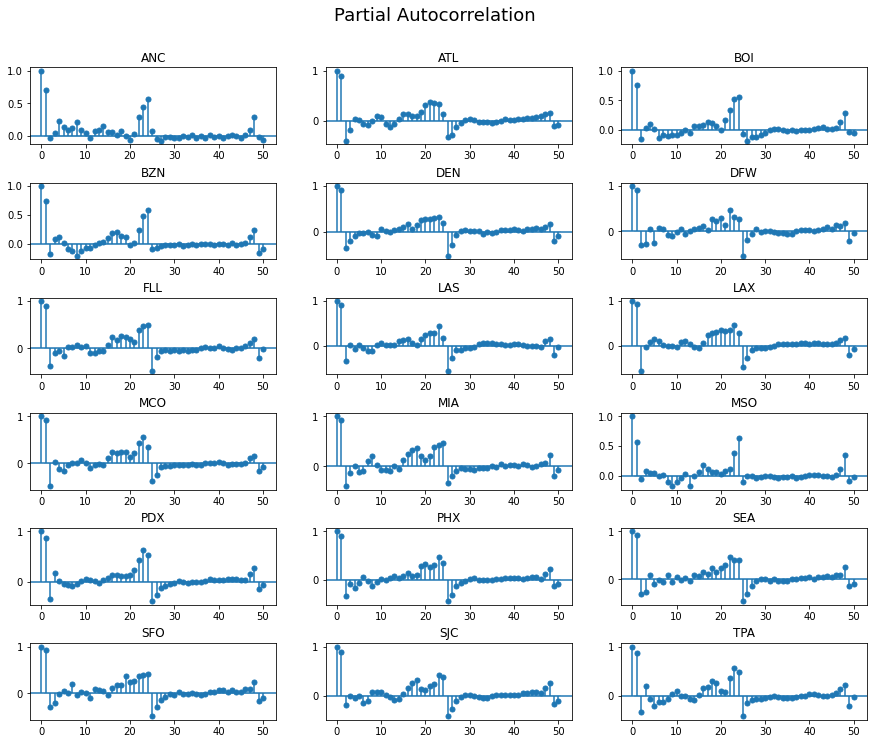

In [48]:
# Partial autocorrelation for each column, 50 lags
plot_partial_autocorrelation(df_nona)

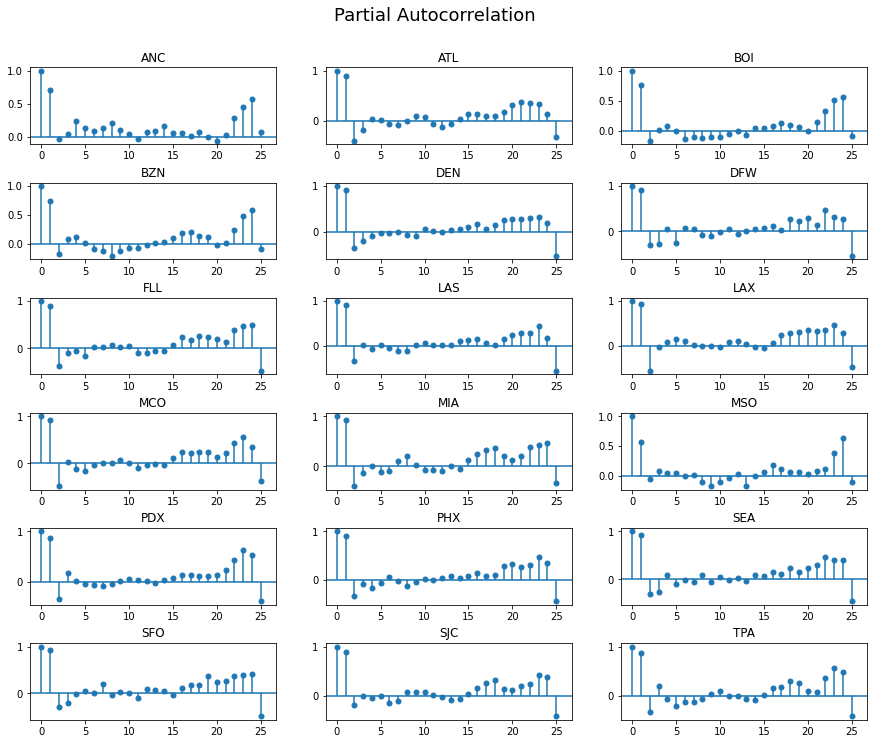

In [49]:
# Partial autocorrelation for each column, 20 lags
plot_partial_autocorrelation(df_nona, 25)

## AD Fuller Test

In [50]:
for i, series in enumerate(df_nona.columns):
    result = adfuller(df_nona[series])
    print(series + ' : ' + str(result[1]))

ANC : 0.046210257914348705
ATL : 4.953252928437895e-06
BOI : 8.162883900534019e-08
BZN : 6.48677439581075e-09
DEN : 2.3639941654866627e-09
DFW : 2.0279127488864312e-07
FLL : 9.385269534700556e-07
LAS : 2.5788911231830933e-12
LAX : 0.026175058639365187
MCO : 8.078398154347634e-08
MIA : 0.0021812449712656323
MSO : 1.6346107785406481e-06
PDX : 0.006447089741747327
PHX : 4.329532111624376e-06
SEA : 0.008339777570868461
SFO : 0.024831494853048846
SJC : 3.3648606622067906e-05
TPA : 2.382536555919093e-06


## Resampling

In [51]:
def resampled(df, period1, period2):
    '''Resampled by day, week, month, quarter or year'''
    
    fig, axs = plt.subplots(9, 2, figsize=(13, 30))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Resampled', fontsize=18, y=0.9)

    for column, ax in zip(df.columns, axs.ravel()):
        df[column].resample(period1).mean().plot(ax = ax, color= 'pink', label=period1)
        df[column].resample(period2).mean().plot(ax=ax, color='red', label=period2)
        ax.legend()
        ax.set_title(column)
    plt.show()

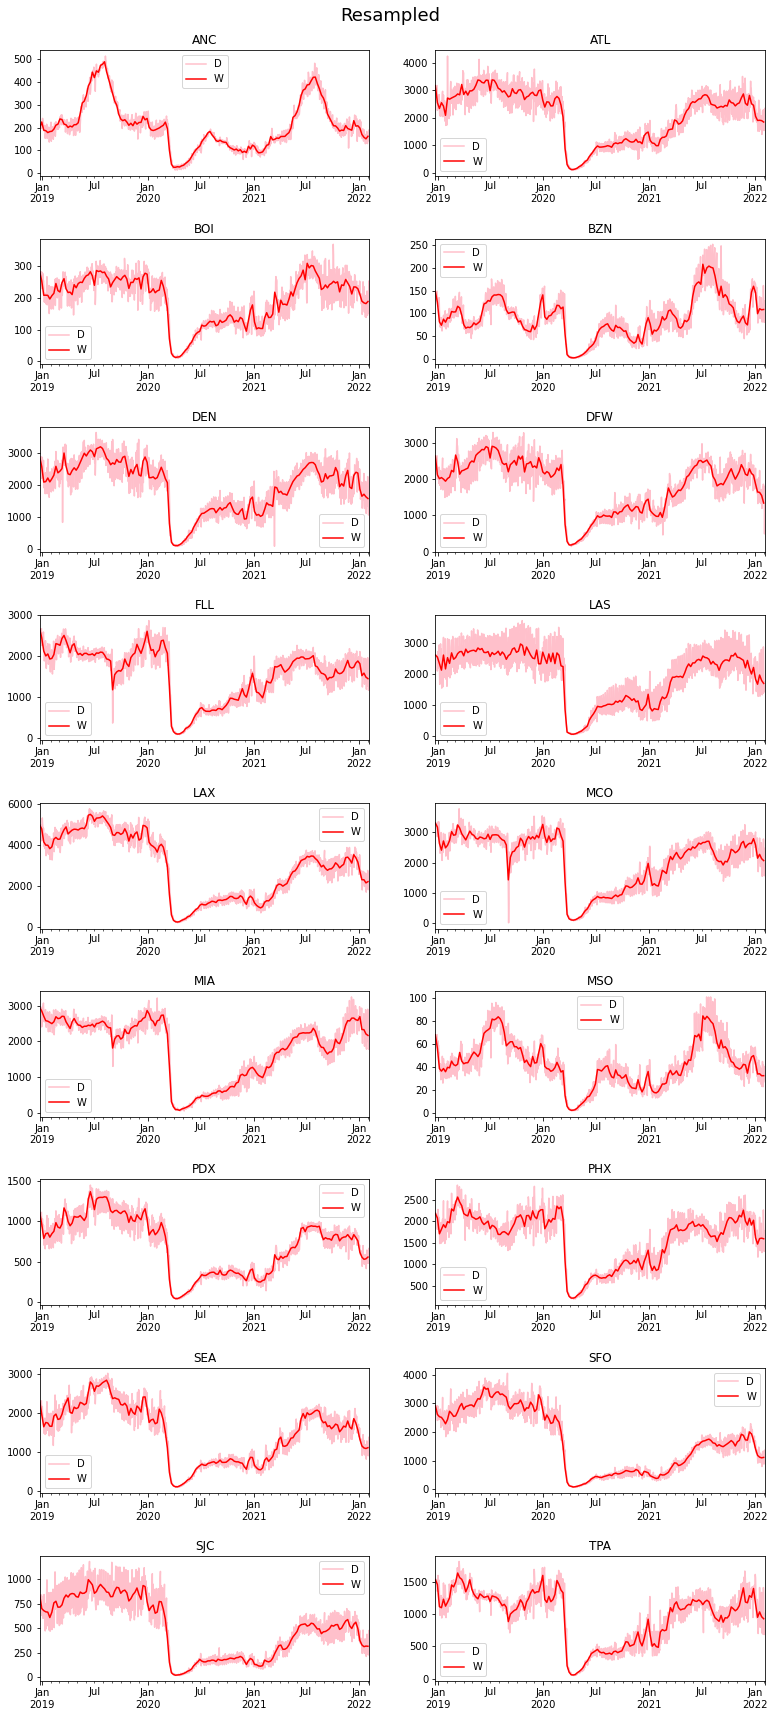

In [52]:
resampled(df_nona,'D','W')

In [53]:
def calendar_frequency(df, freq1, freq2):
    '''Plot data using calendar by calendar frequecy, day,
    week, month, quarter, and year.'''
    
    fig, axs = plt.subplots(9, 2, figsize=(13, 30))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('By Calendar Frequency', fontsize=18, y=0.9)

    for column, ax in zip(df.columns, axs.ravel()):
        df[column].asfreq(freq1).plot(ax = ax, color= 'pink', label=freq1)
        df[column].asfreq(freq2).plot(ax=ax, color='red', label=freq2)
        ax.legend()
        ax.set_title(column)
    plt.show()

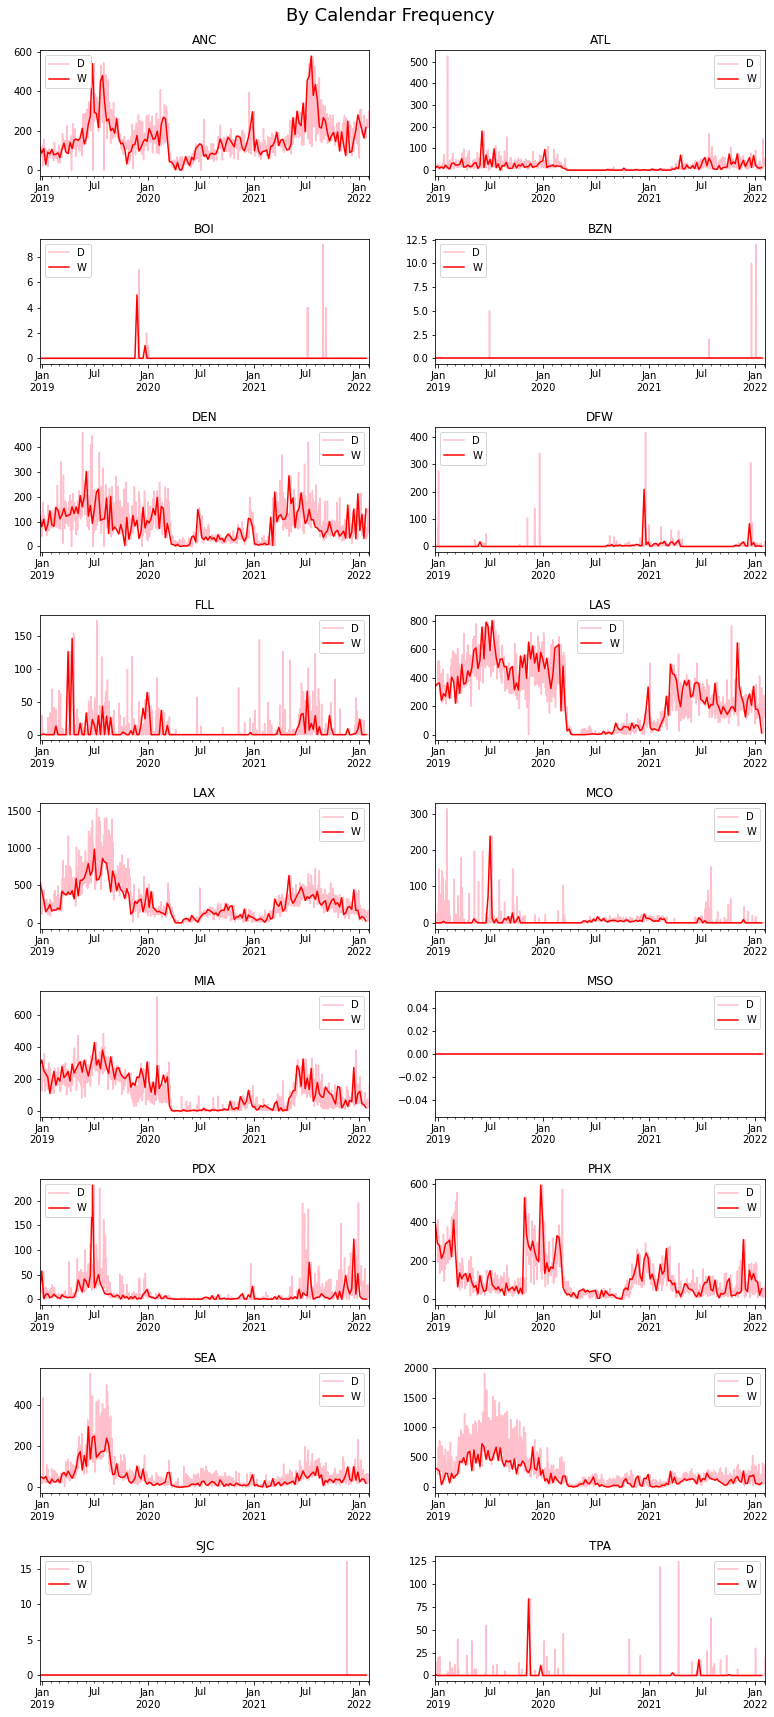

In [54]:
calendar_frequency(df_nona,'D','W')

# Decomposition

In [55]:
decomposition = sm.tsa.seasonal_decompose(df_nona['SJC'])

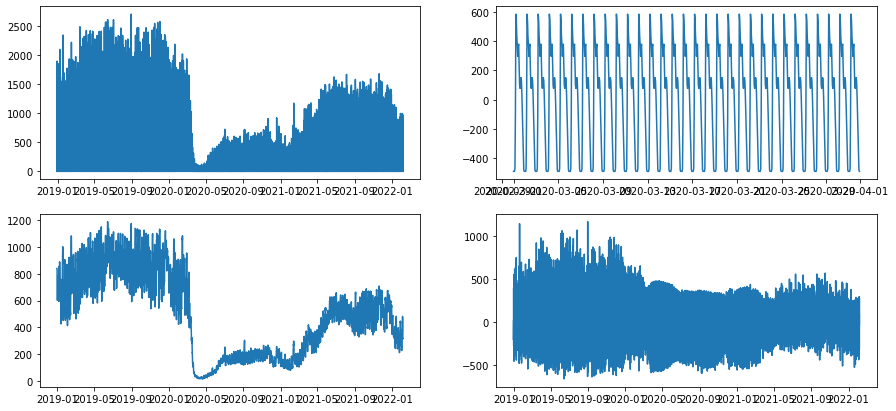

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(15,7))
axs[0,0].plot(df_nona['SJC'])
axs[0,1].plot(decomposition.seasonal['03-2020'])
axs[1,0].plot(decomposition.trend)
axs[1,1].plot(decomposition.resid);

In [57]:
# Save to file
df.to_csv('../data/interim/airports.csv')